In [ ]:
from transformers import CLIPTokenizer
from datasets import load_dataset
from datasets import Image as HuggingFaceImage
from linformer import Linformer
from vit_pytorch.efficient import ViT
import torch
def get_tokenizer() -> CLIPTokenizer:
    return CLIPTokenizer.from_pretrained('openai/clip-vit-base-patch32')
def prepare_data(tokenizer: CLIPTokenizer):
    def add_prompt(example):
        props = example['font_properties']
        character = example['character']
        split = character.split('_')
        if len(split) > 1:
            character = split[0] + 'case ' + split[1]
        else:
            character = split[0]
        prompt = f"a {props['font_serifs']} {character} with {props['width']} width {props['rounding']} corners {props['font_weight']} weight and {props['dynamics']} movement with characteristics that can be described by adjectives {example['font_characteristics']}" 
        example['prompt'] = prompt
        return example
    def map_tokens(example):
        prompt = example['prompt']
        tokens = tokenizer.encode(prompt, padding='max_length', max_length=42)
        example['tokens'] = tokens
        return example
    dataset = load_dataset('json', data_files={'train':'train-metadata.jsonl', 'test':'test-metadata.jsonl'})
    
    train_new_column = ['foo'] * len(dataset['train'])
    dataset['train'] = dataset['train'].add_column('prompt', train_new_column)
    dataset['train'] = dataset['train'].add_column('tokens', train_new_column)
    dataset['train'] = dataset['train'].map(add_prompt)
    dataset['train'] = dataset['train'].map(map_tokens)
    dataset['train'] = dataset['train'].remove_columns(['prompt', 'uniqueId', 'ttf_path', 'font_characteristics', 'font_properties', 'character', 'vit_label'])
    dataset['train'] = dataset['train'].cast_column('image', HuggingFaceImage())
    dataset['train'] = dataset['train'].with_format('torch')
    
    test_new_column = ['bar'] * len(dataset['test'])
    dataset['test'] = dataset['test'].add_column('prompt', test_new_column)
    dataset['test'] = dataset['test'].add_column('tokens', test_new_column)
    dataset['test'] = dataset['test'].map(add_prompt)
    dataset['test'] = dataset['test'].map(map_tokens)
    dataset['test'] = dataset['test'].remove_columns(['prompt', 'uniqueId', 'ttf_path', 'font_characteristics', 'font_properties', 'character', 'vit_label'])
    dataset['test'] = dataset['test'].cast_column('image', HuggingFaceImage())
    dataset['test'] = dataset['test'].with_format('torch')
    return dataset
def get_vit_model(image_size: int, patch_size: int, dim: int, depth: int, num_heads: int, k: int, device: str):
    sequence_length = (image_size//patch_size)**2 + 1
    # for 512x512px image with 32x32px patches: 16x16 + 1 CLS token
    efficient_transformer = Linformer(
        dim=dim,
        seq_len=sequence_length,  
        depth=depth,
        heads=num_heads,
        k=k
    )
    model = ViT(
        dim=dim,
        image_size=image_size,
        patch_size=patch_size,
        num_classes=62,
        transformer=efficient_transformer,
        channels=1,
    )
    return model 
def get_vit(image_size, patch_size, vit_dim, vit_depth, vit_num_heads, k, device, vit_checkpoint_path):
    vit = get_vit_model(image_size=image_size, 
                        patch_size=patch_size, 
                        dim=vit_dim, 
                        depth=vit_depth, 
                        num_heads=vit_num_heads, 
                        k=k, 
                        device=device)
    if vit_checkpoint_path != None:
        vit_checkpoint = torch.load(vit_checkpoint_path)
        vit.load_state_dict(vit_checkpoint['model_state_dict'])
        print('Loaded ViT model from checkpoint:', vit_checkpoint_path)
    return vit


In [ ]:
filtered = dataset['train'].filter(lambda ex: len(ex['tokens']) != 28)
unique = set()
for ex in filtered:
    if len(ex['tokens']) == 35:
        print(ex['prompt'])
    unique.add(len(ex['tokens']))
print(unique)

In [ ]:
import torch.nn as nn
class LinformerLM(nn.Module):
    def __init__(self, num_tokens, dim, seq_len, depth, k = 256, heads = 8, dim_head = None, one_kv_head = False, share_kv = False, reversible = False, dropout = 0.):
        super().__init__()
        self.token_emb = nn.Embedding(num_tokens, dim)
        self.pos_emb = nn.Embedding(seq_len, dim)
        self.linformer = Linformer(dim, seq_len, depth, k = k, heads = heads, dim_head = dim_head,
                one_kv_head = one_kv_head, share_kv = share_kv, reversible = reversible, dropout = dropout)
        # self.to_logits = nn.Linear(dim, num_tokens)

    def forward(self, x):
        x = self.token_emb(x)
        x = self.pos_emb(torch.arange(x.shape[1], device=x.device)) + x
        x = self.linformer(x)
        # out = self.to_logits(x)
        return x

In [ ]:
from torch.optim import AdamW
from x_clip import CLIP
from vit_pytorch.extractor import Extractor
from torch.utils.data import DataLoader
import tqdm as tqdm
device = 'cuda'
clip_tokenizer = get_tokenizer()
dataset = prepare_data(clip_tokenizer)
print(dataset)
def get_dataloaders(train_clip_dataset, test_clip_dataset, batch_size):
    train_loader = DataLoader(dataset=train_clip_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_clip_dataset, batch_size=batch_size, shuffle=True)
    return train_loader, test_loader
train_dataset = dataset['train']
test_dataset = dataset['test']
train_loader, valid_loader = get_dataloaders(train_dataset, test_dataset, 2)
vit_checkpoint = './vit-checkpoints/model-epoch18.pt'
image_size = 512
patch_size = 32
vit_dim = 128
vit_depth = 12
vit_num_heads = 8
k = 64

base_vit = get_vit(image_size, 
                    patch_size, 
                    vit_dim, 
                    vit_depth, 
                    vit_num_heads, 
                    k, 
                    device, 
                    vit_checkpoint)
image_encoder = Extractor(
    base_vit,
    return_embeddings_only = True
)
text_encoder = LinformerLM(
    num_tokens=49408,
    dim = 256,
    seq_len = 42,
    depth = 12,
    heads = 8,
    dim_head = 64,        # be able to set the dimension of each head in multi-head attention
    k = 128,               # this is the k that the key/values are projected to along the sequence dimension
    one_kv_head = True,    # share one key/value head across all heads
    share_kv = False,      # share the same projection for keys and values
    reversible = False,      # make network reversible, like Reformer
)
clip = CLIP(
    image_encoder = image_encoder,
    text_encoder = text_encoder,
    dim_image=128,
    dim_text=256,
    dim_latent=128,
    text_encode_without_mask=True,
    use_all_token_embeds=True,
    text_has_cls_token=False,
    visual_has_cls_token=True,
).to(device)
def prepare_batch(batch):
    batch_imgs = batch['image']
    batch_tokens = batch['tokens']
    batch_imgs = batch_imgs[:, :, :, 0].unsqueeze(-1)
    batch_imgs = batch_imgs.permute(0, 3, 1, 2)
    batch_imgs = batch_imgs.type('torch.FloatTensor')
    return batch_imgs, batch_tokens
for batch in train_loader:
    batch_imgs, batch_tokens = prepare_batch(batch)
    # batch_imgs.to(device)
    batch_tokens = batch_tokens.to(device)
    batch_imgs = batch_imgs.to(device)
    loss = clip(batch_tokens, batch_imgs, return_loss=True)
    loss.backward()
lr=3e-5
def get_trainable_params(model):
    return [params for params in model.parameters() if params.requires_grad]
optimizer = AdamW(get_trainable_params(clip), lr=lr) # DALLE-pytorch setup
for epoch in range(0, 10):
    epoch_loss = 0
    epoch_accuracy = 0
    for batch in tqdm(train_loader):
        batch_imgs, batch_tokens = prepare_batch(batch)
        # batch_imgs.to(device)
        batch_tokens = batch_tokens.to(device)
        batch_imgs = batch_imgs.to(device)
        loss = clip(batch_tokens, batch_imgs, return_loss=True)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # acc = (output.argmax(dim=1) == batch_labels).float().mean()
        # epoch_accuracy += acc / len(train_loader)
        # epoch_loss += loss / len(train_loader)

In [ ]:
from transformers import AutoTokenizer, CLIPTextModel
import torch
tokenizer = AutoTokenizer.from_pretrained('openai/clip-vit-base-patch32')
text_encoder = CLIPTextModel.from_pretrained('openai/clip-vit-base-patch32')
text_encoder.config.bos_token_id = tokenizer.bos_token_id
text_encoder.config.eos_token_id = tokenizer.eos_token_id
text_encoder.config.pad_token_id = tokenizer.pad_token_id
x = torch.randint(0, tokenizer.vocab_size, (2, 42))
out = text_encoder(x)
print(x.shape, out)


In [ ]:
print(text_encoder.config)

In [1]:
import os
from transformers import CLIPTextModel
from x_clip_train import get_tokenizer, get_vit
import torch
from x_clip import CLIP
from vit_pytorch.extractor import Extractor

image_size = 512
patch_size = 32
vit_dim = 512
vit_depth = 12
vit_num_heads = 8
k = 64
base_vit = get_vit(image_size, 
                    patch_size, 
                    vit_dim, 
                    vit_depth, 
                    vit_num_heads, 
                    k,
                    './vit-checkpoints/model-512-epoch9.pt')
image_encoder = Extractor(
    base_vit,
    return_embeddings_only = True
)
clip_tokenizer = get_tokenizer(True)
text_encoder = CLIPTextModel.from_pretrained('openai/clip-vit-base-patch32')
text_encoder.resize_token_embeddings(len(clip_tokenizer))
path = os.path.join(os.getcwd(), 'checkpoint_clip_grad_accum', 'clip-9.pt')
checkpoint = torch.load(path)
clip = CLIP(
    image_encoder = image_encoder,
    text_encoder = text_encoder,
    dim_image=512,
    dim_text=512,
    dim_latent=512,
    text_encode_without_mask=False,
    use_all_token_embeds=False,
    text_has_cls_token=True,
    visual_has_cls_token=True,
    num_text_tokens=text_encoder.vocab_size,
    text_pad_id=clip_tokenizer.pad_token_id,
    text_eos_id=clip_tokenizer.eos_token_id,
    use_mlm=True,
    mlm_mask_token_id=clip_tokenizer.mask_token_id,
    mlm_pad_token_id=clip_tokenizer.pad_token_id,
    mlm_mask_ignore_token_ids=[clip_tokenizer.bos_token_id]
).to('cuda')
clip.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch']
loss = checkpoint['loss']
print('Loaded model from checkpoint:', path)

Loaded ViT model from checkpoint: ./vit-checkpoints/model-512-epoch9.pt
Added special tokens:  {'mask_token': '<|mask_token|>'}


Some weights of the model checkpoint at openai/clip-vit-base-patch32 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.3.self_attn.k_proj.bias', 'vision_model.encoder.layers.9.self_attn.v_proj.weight', 'vision_model.encoder.layers.10.mlp.fc2.bias', 'vision_model.encoder.layers.10.self_attn.q_proj.bias', 'vision_model.encoder.layers.7.self_attn.out_proj.bias', 'vision_model.encoder.layers.4.layer_norm1.bias', 'vision_model.encoder.layers.7.mlp.fc2.weight', 'vision_model.encoder.layers.6.self_attn.q_proj.bias', 'vision_model.encoder.layers.8.self_attn.v_proj.weight', 'vision_model.encoder.layers.0.layer_norm1.bias', 'vision_model.encoder.layers.3.self_attn.q_proj.weight', 'vision_model.encoder.layers.5.mlp.fc2.weight', 'vision_model.encoder.layers.9.mlp.fc2.bias', 'vision_model.encoder.layers.0.layer_norm2.bias', 'vision_model.encoder.layers.0.layer_norm2.weight', 'vision_model.encoder.layers.11.self_attn.k_proj.weight', 'vision_model.encoder.layers.6.self_attn

Loaded model from checkpoint: d:\font-diffusion\checkpoint_clip_grad_accum\clip-9.pt


In [ ]:
from x_clip_train import prepare_batch, get_dataloaders, get_tokenizer, prepare_data
from transformers import CLIPTextModel
clip_tokenizer = get_tokenizer(True)
clip_tokenizer.pad_token_id = 0
print(clip_tokenizer.all_special_ids)
print(clip_tokenizer.model_max_length)
print(clip_tokenizer.pad_token_id)
# clip_tokenizer.add_special_tokens({'mask_token':'<|mask_token|>', 'cls_token': '<|cls_token|>'})
# print(clip_tokenizer.special_tokens_map)
# model = CLIPTextModel.from_pretrained('openai/clip-vit-base-patch32')
# model.resize_token_embeddings(len(clip_tokenizer))
# dataset = prepare_data(clip_tokenizer)


In [2]:
from x_clip_train import prepare_batch, get_dataloaders, get_tokenizer, prepare_data
clip_tokenizer = get_tokenizer(True)
dataset = prepare_data(clip_tokenizer)
train_dataset, test_dataset = dataset['train'], dataset['test']
train_loader, valid_loader = get_dataloaders(train_dataset, test_dataset, 16)
for batch in train_loader:
    batch_imgs, batch_tokens = prepare_batch(batch)
    break

Added special tokens:  {'mask_token': '<|mask_token|>'}


Found cached dataset json (C:/Users/Michael Labarca/.cache/huggingface/datasets/json/default-c772ad4eb6d31de9/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51)


  0%|          | 0/2 [00:00<?, ?it/s]

Map:   0%|          | 0/12090 [00:00<?, ? examples/s]

Map:   0%|          | 0/12090 [00:00<?, ? examples/s]

Map:   0%|          | 0/208 [00:00<?, ? examples/s]

Map:   0%|          | 0/208 [00:00<?, ? examples/s]

In [3]:
# from x_clip_train import prepare_batch, get_dataloaders, get_tokenizer, prepare_data
# clip_tokenizer = get_tokenizer(True)
# dataset = prepare_data(clip_tokenizer)
# train_dataset, test_dataset = dataset['train'], dataset['test']
# train_loader, valid_loader = get_dataloaders(train_dataset, test_dataset, 16)
# for batch in train_loader:
#     batch_imgs, batch_tokens = prepare_batch(batch)
    # batch_tokens = batch_tokens.type(torch.int32)
index_ = 4
batch_imgs, batch_tokens = batch_imgs.to('cuda'), batch_tokens.to('cuda')
out = clip(batch_tokens, batch_imgs[index_].unsqueeze(0), return_encodings=True)
print(out[0].last_hidden_state.shape)
print(out[1].shape)
print(batch_tokens[0])
# break

torch.Size([16, 77, 512])
torch.Size([1, 257, 512])
tensor([49406,   320, 16982,   803,   878, 32578,  2068,   333,   593,  6307,
        23571,  2393,  1241, 19584,  6307,  3868,   537, 16363,  5208,   593,
        26037,   682,   753,   655, 14671,   638, 45512,  7570,  2794,  8911,
         4129,  7651, 49407,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0], device='cuda:0')


tensor([49406,   320, 16982,   803,   878, 32578,  2068,   333,   593,  6307,
        23571,  2393,  1241, 19584,  6307,  3868,   537, 16363,  5208,   593,
        26037,   682,   753,   655, 14671,   638, 45512,  7570,  2794,  8911,
         4129,  7651, 49407,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0], device='cuda:0')
torch.Size([16, 77, 512])
torch.Size([16, 512])
tensor([[-0.0104, -0.0126,  0.0692, -0.0122, -0.0124,  0.0227,  0.0524,  0.0733,
          0.0162,  0.0008,  0.0194,  0.0062,  0.0055,  0.0042,  0.0424,  0.0496]],
       device='cuda:0', grad_fn=<MmBackward0>)
tensor(7, device='cuda:0')
<|startoftext|>a sans serif lowercase k with regular width square corners black weight and st

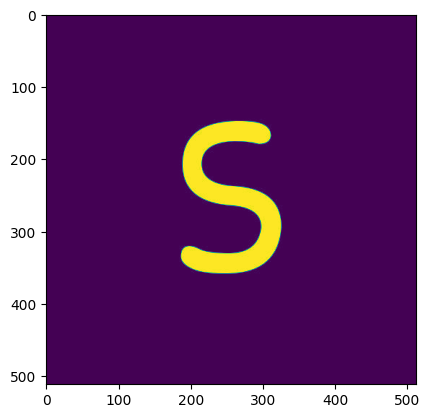

In [4]:
from sentence_transformers import util
import matplotlib.pyplot as plt
print(batch_tokens[0])
print(out[0].last_hidden_state.shape)
print(out[0].pooler_output.shape)
cos_scores = util.cos_sim(out[1].squeeze(0)[0], out[0].pooler_output)
argmax = torch.argmax(cos_scores)
print(cos_scores)
print(argmax)
print(clip_tokenizer.decode(batch_tokens[argmax]))
plt.imshow(batch_imgs[index_].squeeze(0).cpu())

Added special tokens:  {'mask_token': '<|mask_token|>'}


Found cached dataset json (C:/Users/Michael Labarca/.cache/huggingface/datasets/json/default-c772ad4eb6d31de9/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51)


  0%|          | 0/2 [00:00<?, ?it/s]

Loading cached processed dataset at C:\Users\Michael Labarca\.cache\huggingface\datasets\json\default-c772ad4eb6d31de9\0.0.0\0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51\cache-b26c26fef36d8e27.arrow
Loading cached processed dataset at C:\Users\Michael Labarca\.cache\huggingface\datasets\json\default-c772ad4eb6d31de9\0.0.0\0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51\cache-0ae0807558d14830.arrow
Loading cached processed dataset at C:\Users\Michael Labarca\.cache\huggingface\datasets\json\default-c772ad4eb6d31de9\0.0.0\0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51\cache-f46cb15ec73d6a31.arrow
Loading cached processed dataset at C:\Users\Michael Labarca\.cache\huggingface\datasets\json\default-c772ad4eb6d31de9\0.0.0\0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51\cache-9b92a7b894339c8e.arrow


torch.Size([1, 257, 512]) torch.Size([16, 512]) torch.Size([16, 77, 512])
tensor([[-0.0528, -0.0548, -0.0532, -0.0372, -0.0361, -0.0338, -0.0776, -0.0777,
         -0.0674, -0.0806, -0.0631, -0.0190, -0.0204, -0.0151, -0.0747, -0.0460]],
       device='cuda:0', grad_fn=<MmBackward0>)
torch.Size([1, 257, 512]) torch.Size([16, 512]) torch.Size([16, 77, 512])
tensor([[ 0.0461, -0.0130,  0.0527,  0.0122,  0.0121,  0.0086, -0.0137, -0.0768,
          0.0012, -0.0256,  0.0109, -0.0509, -0.0345, -0.0233,  0.0024,  0.0078]],
       device='cuda:0', grad_fn=<MmBackward0>)
torch.Size([1, 257, 512]) torch.Size([16, 512]) torch.Size([16, 77, 512])
tensor([[-0.0253, -0.0441, -0.0292, -0.0799, -0.0777, -0.0738, -0.0564, -0.0680,
         -0.0261, -0.0553, -0.0155, -0.0374, -0.0335, -0.0022, -0.0321, -0.0020]],
       device='cuda:0', grad_fn=<MmBackward0>)
torch.Size([1, 257, 512]) torch.Size([16, 512]) torch.Size([16, 77, 512])
tensor([[-0.0133, -0.0643, -0.0127, -0.0130, -0.0014, -0.0222, -0.0268,

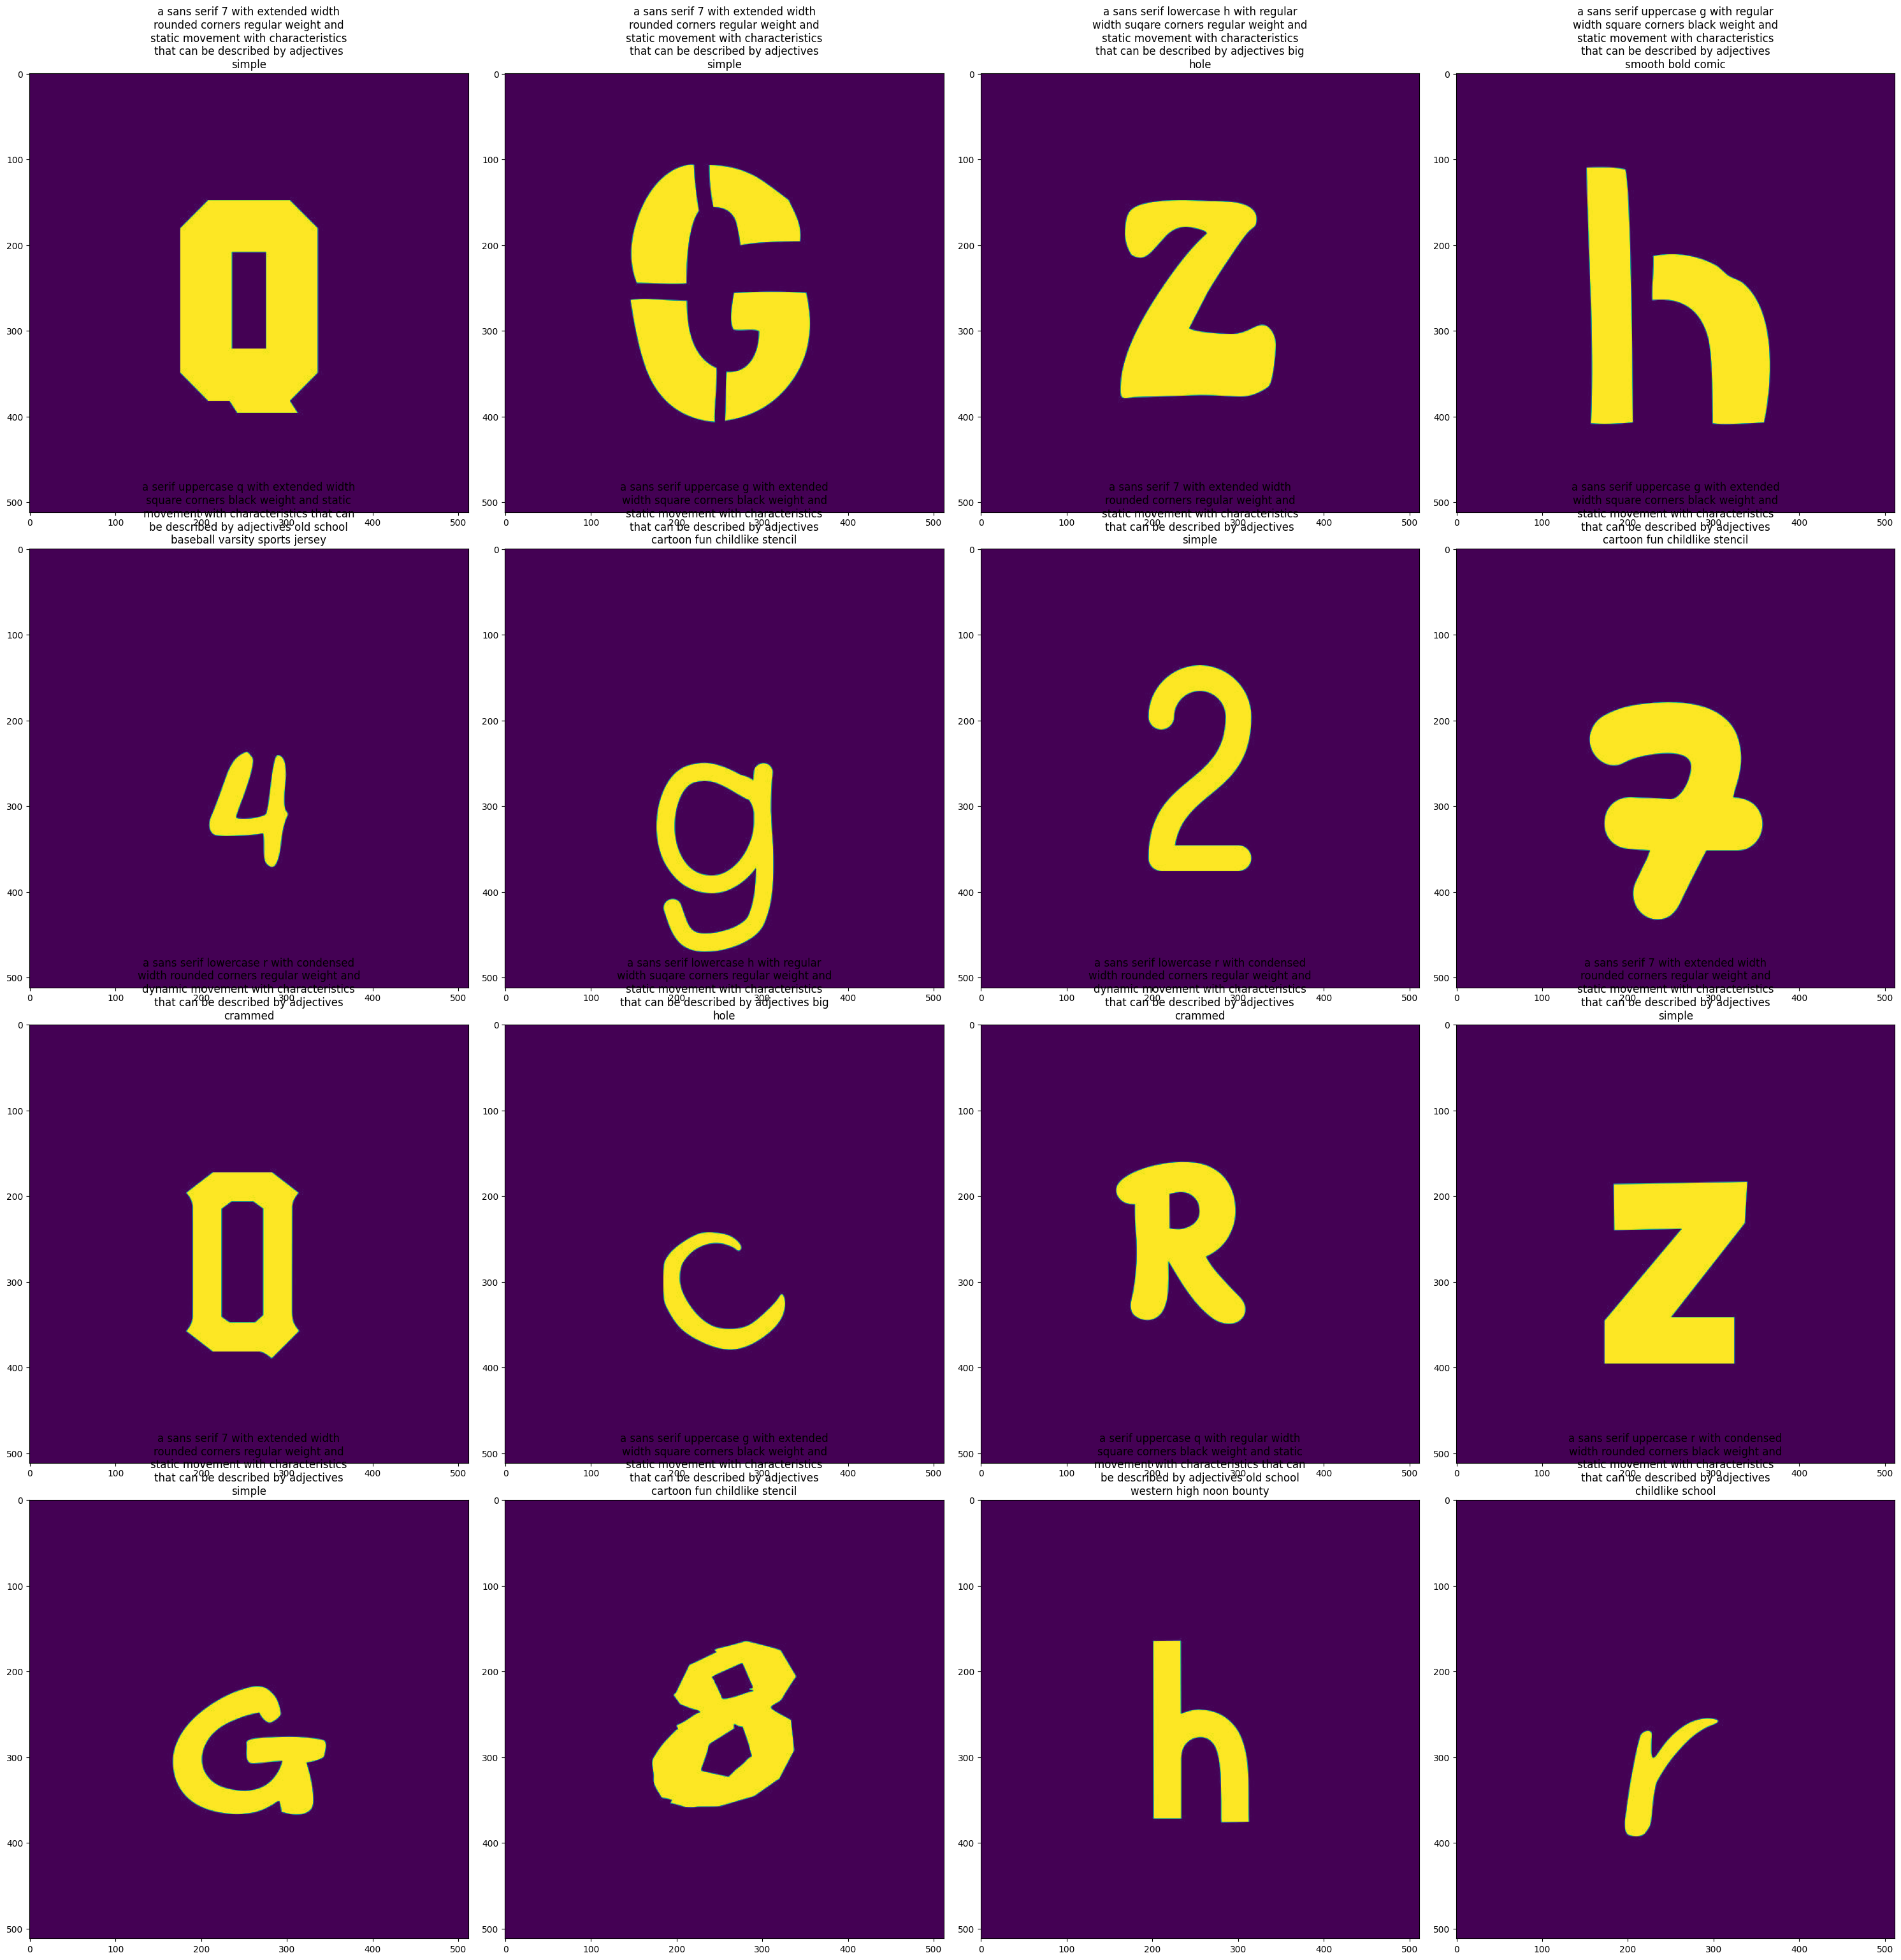

In [14]:
from x_clip_train import prepare_batch, get_dataloaders, get_tokenizer, prepare_data
from sentence_transformers import util 
import matplotlib.pyplot as plt
import textwrap
BATCH_SIZE=16
clip_tokenizer = get_tokenizer(True)
dataset = prepare_data(clip_tokenizer)
train_dataset, test_dataset = dataset['train'], dataset['test']
train_loader, valid_loader = get_dataloaders(train_dataset, test_dataset, BATCH_SIZE)

def get_string_between_tokens(s, start_token, end_token):
    start_index = s.find(start_token) + len(start_token)
    end_index = s.find(end_token, start_index)
    return s[start_index:end_index]

GRAPH_DIM = 4
fig, axs = plt.subplots(BATCH_SIZE//GRAPH_DIM, BATCH_SIZE//GRAPH_DIM, figsize=(30,30))
plt.tight_layout()

EOS_TOKEN = clip_tokenizer.eos_token
BOS_TOKEN = clip_tokenizer.bos_token
# outs = []
for batch in train_loader:
    batch_imgs, batch_tokens = prepare_batch(batch)
    # batch_tokens = batch_tokens.type(torch.int32)
    batch_imgs, batch_tokens = batch_imgs.to('cuda'), batch_tokens.to('cuda')
    # out = clip(batch_tokens, batch_imgs, return_encodings=True)
    break
for i in range(len(batch_imgs)):
    out = clip(batch_tokens, batch_imgs[i].unsqueeze(0), return_encodings=True)
    print(out[1].shape, out[0].pooler_output.shape, out[0].last_hidden_state.shape)
    cos_scores = util.cos_sim(out[1][:,0], out[0].pooler_output)
    argmax = torch.argmax(cos_scores)
    token_label = clip_tokenizer.decode(batch_tokens[argmax])
    label = get_string_between_tokens(token_label, BOS_TOKEN, EOS_TOKEN)
    label = "\n".join(textwrap.wrap(label, 40))
    print(cos_scores)
    axs[i%GRAPH_DIM, i//GRAPH_DIM].imshow(batch_imgs[i].squeeze(0).cpu())
    axs[i%GRAPH_DIM, i//GRAPH_DIM].set_title(label)
    # fig_list.append(fig)
    # outs.append(label, batch_imgs[i])
    del out, cos_scores, argmax, token_label
plt.show()
#torch.Size([16, 77, 512])
# torch.Size([32, 257, 512])

In [13]:
print(torch.__version__)

2.0.0


In [4]:
##display predicted tokens per img in batch_imgs
fig_list = []
out = clip(batch_tokens, batch_imgs, return_encodings=True)
for i, img in enumerate(batch_imgs):
    out = clip(batch_tokens, batch_imgs[i].unsqueze(0), return_encodings=True)
    cos_scores = util.cos_sim(out[1].squeeze(0)[0], out[0].last_hidden_state[i, 0])
    argmax = torch.argmax(cos_scores)
    print(clip_tokenizer.decode(batch_tokens[argmax]))
    plt.imshow(batch_imgs[i].squeeze(0).cpu())
    del out, cos_scores, argmax


NameError: name 'clip' is not defined